In [1]:
!pip install -q torchinfo

In [2]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn, optim
from torchinfo import summary

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")
print(is_cuda, device)

True cuda


In [4]:
seed = 1202
random.seed(seed)         # python seed
np.random.seed(seed)      # numpy seed
torch.manual_seed(seed)   # torch seed
if device == 'cuda':
  torch.cuda.manual_seed_all(seed)  # gpu seed

In [5]:
!wget https://www.cryptodatadownload.com/cdd/Bithumb_BTCKRW_d.csv

--2025-07-09 00:51:36--  https://www.cryptodatadownload.com/cdd/Bithumb_BTCKRW_d.csv
Resolving www.cryptodatadownload.com (www.cryptodatadownload.com)... 35.173.69.207
Connecting to www.cryptodatadownload.com (www.cryptodatadownload.com)|35.173.69.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111438 (109K) [text/csv]
Saving to: ‘Bithumb_BTCKRW_d.csv’

Bithumb_BTCKRW_d.cs 100%[===================>] 108.83K  --.-KB/s    in 0.06s   

2025-07-09 00:51:36 (1.93 MB/s) - ‘Bithumb_BTCKRW_d.csv’ saved [111438/111438]



In [6]:
df = pd.read_csv("/kaggle/working/Bithumb_BTCKRW_d.csv", skiprows=1)
df['Date'] = df['Date'].apply(pd.Timestamp)
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
print(df.shape)
print(df)

(1267, 8)
            Unix Timestamp  Symbol      Open      High       Low     Close  \
Date                                                                         
2017-05-22    1.495411e+09  BTCKRW   3027000   3195000   2966000   3104000   
2017-05-23    1.495498e+09  BTCKRW   3104000   3281000   3081000   3206000   
2017-05-24    1.495584e+09  BTCKRW   3206000   4314000   3206000   4175000   
2017-05-25    1.495670e+09  BTCKRW   4175000   4840000   3102000   4199000   
2017-05-26    1.495757e+09  BTCKRW   4199000   4200000   2900000   3227000   
...                    ...     ...       ...       ...       ...       ...   
2020-11-16    1.605485e+09  BTCKRW  17679000  18440000  17560000  18264000   
2020-11-17    1.605571e+09  BTCKRW  18264000  19411000  18179000  19350000   
2020-11-18    1.605658e+09  BTCKRW  19350000  20300000  19058000  19713000   
2020-11-19    1.605744e+09  BTCKRW  19713000  20026000  19379000  19799000   
2020-11-20    1.605830e+09  BTCKRW  19799000  20151000

In [7]:
df_close = df.loc[:, ["Close"]]
print(df_close.tail())

               Close
Date                
2020-11-16  18264000
2020-11-17  19350000
2020-11-18  19713000
2020-11-19  19799000
2020-11-20  20072000


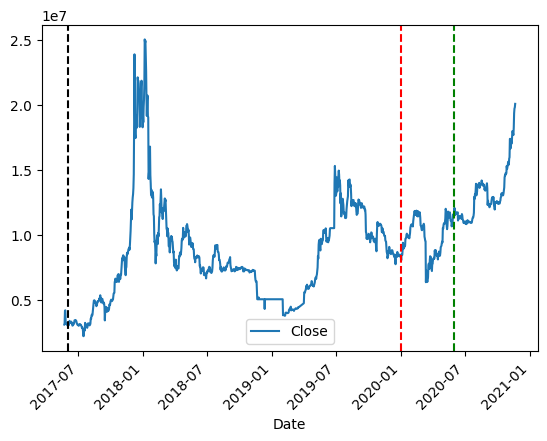

In [8]:
ax = df_close.plot(rot=45)
ax.axvline("2017-06-01", linestyle="--", c="black")
ax.axvline("2020-01-01", linestyle="--", c="red")
ax.axvline("2020-06-01", linestyle="--", c="green")

In [9]:
df_train = df_close[
  (df_close.index >= "2017-06-01")&(df_close.index < "2020-01-01")
]
print(df_train[:5])

              Close
Date               
2017-06-01  3142000
2017-06-02  3169000
2017-06-03  3110000
2017-06-04  3061000
2017-06-05  3188000


In [10]:
scaler = MinMaxScaler()
data = scaler.fit_transform(df_train[:5])
data

array([[0.63779528],
       [0.8503937 ],
       [0.38582677],
       [0.        ],
       [1.        ]])

In [11]:
scaler.inverse_transform(data)

array([[3142000.],
       [3169000.],
       [3110000.],
       [3061000.],
       [3188000.]])

In [12]:
class BitcoinDataset(Dataset):
  def __init__(self, split="train", seq_len=4):
    self.split = split
    self.seq_len = seq_len

    self.date_range = {
      "train": ["2017-06-01", "2020-01-01"],
      "val": ["2020-01-01", "2020-06-01"],
      "test": ["2020-06-01", "2020-11-21"]
    }

    self.data = self._load_data(self.date_range[self.split])
    self.data, self.labels = self._transform(self.data, self.seq_len)

  def _load_data(self, date_range):
    df = pd.read_csv("/kaggle/working/Bithumb_BTCKRW_d.csv", skiprows=1)
    df['Date'] = df['Date'].apply(pd.Timestamp)
    df = df.sort_values('Date')
    df.set_index('Date', inplace=True)

    df_close = df.loc[:, ["Close"]]
    df = df_close[
      (df_close.index >= date_range[0])&(df_close.index < date_range[1])
    ]

    self.scaler = MinMaxScaler()
    data = self.scaler.fit_transform(df)
    return data

  def _transform(self, data, seq_len):
    x, y = [], []

    for i in range(len(data) - seq_len - 1):
      x_i = data[i:i+seq_len]
      y_i = data[i+1:i+seq_len+1]
      x.append(x_i)
      y.append(y_i)

    x_tensor = torch.FloatTensor(x)
    y_tensor = torch.FloatTensor(y)

    return x_tensor, y_tensor

  def __getitem__(self, i):
    return self.data[i], self.labels[i]

  def __len__(self):
    return len(self.data)

In [13]:
trainset = BitcoinDataset()
valset = BitcoinDataset(split="val")
testset = BitcoinDataset(split="test")

print(len(trainset), len(valset), len(testset))

927 147 168


In [14]:
def plot_sequence(x, y):
  plt.ylabel("Scaled Close")
  plt.xlabel("Time Bars")
  plt.plot(range(len(x)), x, color='r', label='Features')
  plt.plot(range(1, len(x)+1), y, color='b', linestyle='--', label='Target')
  plt.legend()

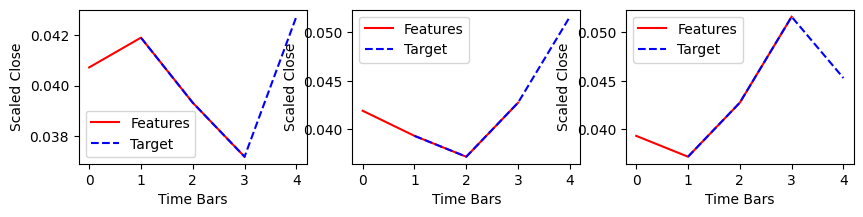

In [15]:
plt.figure(figsize=(10,2))
for i, (x, y) in enumerate(trainset):
  plt.subplot(1, 3, i+1)
  plot_sequence(x, y)

  if i == 2:
    break

In [57]:
model = nn.LSTM(4, 4)
summary(model, (1, 4))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [1, 4]                    160
Total params: 160
Trainable params: 160
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [58]:
output, (hidden_state, cell_state) = model(torch.randn((1,4)).to(device))
print(output)
print(hidden_state)
print(cell_state)

tensor([[ 0.0325, -0.1414,  0.1703, -0.0278]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([[ 0.0325, -0.1414,  0.1703, -0.0278]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([[ 0.0754, -0.3095,  0.3254, -0.0422]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)


In [59]:
def train(model, dataloader, criterion, optimizer, epoch, device):
  model.train()

  running_loss = 0

  with tqdm(dataloader) as pbar:
    for i, (features, targets) in enumerate(pbar):
      features = features.to(device)
      targets = targets.to(device)

      optimizer.zero_grad()

      outputs, _ = model(features)
      loss = criterion(outputs, targets)

      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      pbar.set_postfix(loss=loss.item())

  return running_loss/len(dataloader)

In [60]:
def validation(model, dataloader, criterion, epoch, device):
  model.eval()

  running_loss = 0

  with tqdm(dataloader) as pbar:
    with torch.no_grad():
      for i, (features, targets) in enumerate(pbar):
        features = features.to(device)
        targets = targets.to(device)

        outputs, _ = model(features)
        loss = criterion(outputs, targets)

        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

  return running_loss/len(dataloader)

In [61]:
EPOCH = 60
BATCH_SIZE = 128
NUM_WORKERS = 2
LR = 0.1

trainset = BitcoinDataset()
valset = BitcoinDataset(split="val")
testset = BitcoinDataset(split="test")

train_loader = DataLoader(
  dataset=trainset,
  batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
)
val_loader = DataLoader(
  dataset=valset,
  batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
)
test_loader = DataLoader(
  dataset=testset,
  batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
)

# Model
# model = nn.LSTM(4, 4)
# input_size=1임에도 불구하고 input_size=4로 LSTM을 선언해서 오류
# LSTM 입력 차원을 1로 수정
model = nn.LSTM(1, 4)

# Optimizer, Loss, Scheduler
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)

model = model.to(device)
criterion = criterion.to(device)

# Start Training
min_loss = 999
for epoch in range(EPOCH):
  print("LR:", scheduler.get_last_lr())

  tloss = train(model, train_loader, criterion, optimizer, epoch, device)
  vloss = validation(model, val_loader, criterion, epoch, device)
  print(f'[{epoch}/{EPOCH}] valid loss: {vloss:.4f}\n')
  scheduler.step()

  if vloss < min_loss:
    print(f"Update Best Model: {vloss}")
    torch.save(model.state_dict(), "best.pth")
    min_loss = vloss

LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 29.00it/s, loss=0.357]


[0/60] valid loss: 0.2611

Update Best Model: 0.2611112892627716
LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 24.11it/s, loss=0.224]


[1/60] valid loss: 0.1615

Update Best Model: 0.16153015196323395
LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 29.51it/s, loss=0.18]


[2/60] valid loss: 0.1305

Update Best Model: 0.13052361831068993
LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 27.12it/s, loss=0.106]


[3/60] valid loss: 0.0762

Update Best Model: 0.07618359103798866
LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 29.49it/s, loss=0.0484]


[4/60] valid loss: 0.0334

Update Best Model: 0.03342581354081631
LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 28.39it/s, loss=0.0295]


[5/60] valid loss: 0.0210

Update Best Model: 0.02104174718260765
LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 25.64it/s, loss=0.023]


[6/60] valid loss: 0.0157

Update Best Model: 0.015738517977297306
LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 30.97it/s, loss=0.0224]


[7/60] valid loss: 0.0155

Update Best Model: 0.015545842237770557
LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 29.22it/s, loss=0.0223]


[8/60] valid loss: 0.0157

LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 27.11it/s, loss=0.0238]


[9/60] valid loss: 0.0165

LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 26.36it/s, loss=0.024]


[10/60] valid loss: 0.0168

LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 29.18it/s, loss=0.0249]


[11/60] valid loss: 0.0177

LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 30.73it/s, loss=0.0276]


[12/60] valid loss: 0.0200

LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 29.56it/s, loss=0.028]


[13/60] valid loss: 0.0195

LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 25.96it/s, loss=0.023]


[14/60] valid loss: 0.0165

LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 29.85it/s, loss=0.0223]


[15/60] valid loss: 0.0157

LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 28.36it/s, loss=0.0198]


[16/60] valid loss: 0.0142

Update Best Model: 0.01422900054603815
LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 28.61it/s, loss=0.0192]


[17/60] valid loss: 0.0138

Update Best Model: 0.013805218040943146
LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 30.09it/s, loss=0.0186]


[18/60] valid loss: 0.0134

Update Best Model: 0.013430634513497353
LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 27.69it/s, loss=0.0188]


[19/60] valid loss: 0.0135

LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 29.16it/s, loss=0.0187]


[20/60] valid loss: 0.0134

LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 31.15it/s, loss=0.0185]


[21/60] valid loss: 0.0133

Update Best Model: 0.013313642237335443
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 27.59it/s, loss=0.0181]


[22/60] valid loss: 0.0131

Update Best Model: 0.01310904510319233
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 27.98it/s, loss=0.018]


[23/60] valid loss: 0.0130

Update Best Model: 0.01303692813962698
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 29.62it/s, loss=0.0179]


[24/60] valid loss: 0.0130

Update Best Model: 0.012966553680598736
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 31.39it/s, loss=0.0177]


[25/60] valid loss: 0.0129

Update Best Model: 0.01288077374920249
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 25.48it/s, loss=0.0177]


[26/60] valid loss: 0.0128

Update Best Model: 0.012847392354160547
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 27.89it/s, loss=0.0176]


[27/60] valid loss: 0.0128

Update Best Model: 0.012808053754270077
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 28.52it/s, loss=0.0176]


[28/60] valid loss: 0.0128

Update Best Model: 0.012759230099618435
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 26.16it/s, loss=0.0175]


[29/60] valid loss: 0.0127

Update Best Model: 0.01271962933242321
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 27.92it/s, loss=0.0174]


[30/60] valid loss: 0.0127

Update Best Model: 0.01267419196665287
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 28.51it/s, loss=0.0173]


[31/60] valid loss: 0.0126

Update Best Model: 0.012626469600945711
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 27.35it/s, loss=0.0173]


[32/60] valid loss: 0.0126

Update Best Model: 0.012577437795698643
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 30.14it/s, loss=0.0172]


[33/60] valid loss: 0.0125

Update Best Model: 0.01252620480954647
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 31.34it/s, loss=0.0171]


[34/60] valid loss: 0.0125

Update Best Model: 0.012475657276809216
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 30.48it/s, loss=0.017]


[35/60] valid loss: 0.0124

Update Best Model: 0.012423963751643896
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 28.27it/s, loss=0.0169]


[36/60] valid loss: 0.0124

Update Best Model: 0.01237184228375554
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 29.43it/s, loss=0.0168]


[37/60] valid loss: 0.0123

Update Best Model: 0.012319846078753471
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 31.67it/s, loss=0.0167]


[38/60] valid loss: 0.0123

Update Best Model: 0.012267359998077154
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 27.20it/s, loss=0.0166]


[39/60] valid loss: 0.0122

Update Best Model: 0.012214741669595242
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 28.03it/s, loss=0.0166]


[40/60] valid loss: 0.0122

Update Best Model: 0.012208857806399465
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 23.05it/s, loss=0.0166]


[41/60] valid loss: 0.0122

Update Best Model: 0.0122004603035748
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 30.29it/s, loss=0.0166]


[42/60] valid loss: 0.0122

Update Best Model: 0.012190454639494419
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 29.97it/s, loss=0.0166]


[43/60] valid loss: 0.0122

Update Best Model: 0.012180156074464321
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 25.70it/s, loss=0.0166]


[44/60] valid loss: 0.0122

Update Best Model: 0.01216979743912816
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 28.03it/s, loss=0.0166]


[45/60] valid loss: 0.0122

Update Best Model: 0.012158995494246483
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 25.88it/s, loss=0.0165]


[46/60] valid loss: 0.0121

Update Best Model: 0.012147577479481697
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 28.51it/s, loss=0.0165]


[47/60] valid loss: 0.0121

Update Best Model: 0.0121357929892838
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 30.47it/s, loss=0.0165]


[48/60] valid loss: 0.0121

Update Best Model: 0.012123991968110204
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 30.32it/s, loss=0.0165]


[49/60] valid loss: 0.0121

Update Best Model: 0.012112320400774479
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 26.89it/s, loss=0.0165]


[50/60] valid loss: 0.0121

Update Best Model: 0.012100729625672102
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 22.92it/s, loss=0.0164]


[51/60] valid loss: 0.0121

Update Best Model: 0.012089105788618326
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 27.67it/s, loss=0.0164]


[52/60] valid loss: 0.0121

Update Best Model: 0.01207738509401679
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 30.42it/s, loss=0.0164]


[53/60] valid loss: 0.0121

Update Best Model: 0.012065563583746552
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 28.50it/s, loss=0.0164]


[54/60] valid loss: 0.0121

Update Best Model: 0.012053655693307519
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 27.84it/s, loss=0.0164]


[55/60] valid loss: 0.0120

Update Best Model: 0.012041660957038403
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 23.41it/s, loss=0.0163]


[56/60] valid loss: 0.0120

Update Best Model: 0.012029577745124698
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 27.83it/s, loss=0.0163]


[57/60] valid loss: 0.0120

Update Best Model: 0.012017406290397048
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 29.64it/s, loss=0.0163]


[58/60] valid loss: 0.0120

Update Best Model: 0.01200514892116189
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 29.17it/s, loss=0.0163]

[59/60] valid loss: 0.0120

Update Best Model: 0.011992809595540166


In [72]:
def test(model, dataloader, device):
  model.eval()

  predicts = []

  with tqdm(dataloader) as pbar:
    with torch.no_grad():
      for i, (features, _) in enumerate(pbar):
        features = features.to(device)

        outputs, _ = model(features)
        y_pred = outputs[:, -1, 0]  # (batch_size,) 형태로 1차원 만들기
        predicts.append(y_pred)

  return torch.cat(predicts)

In [73]:
def show_plot(model, dataloader, device):

    actual = dataloader.dataset.data[:, -1].squeeze() # shape이 (N, 1)이라면 1차원으로 변환
    predicts = test(model, dataloader, device).cpu().numpy()

    # 예: hidden_state[0] 사용
    if predicts.ndim == 2:
        predicts = predicts[:, 0] # 또는 평균값: predicts.mean(axis=1)

    # Pandas의 DataFrame 생성 시 각 column은 반드시 1차원 배열
    df = pd.DataFrame({"actual": actual, "predicted": predicts})

    # 역정규화
    df["actual"] = scaler.inverse_transform(df["actual"].values.reshape(-1, 1)).reshape(-1)
    df["predicted"] = scaler.inverse_transform(df["predicted"].values.reshape(-1, 1)).reshape(-1)
    df.plot(figsize=(14,5))

In [74]:
model = nn.LSTM(1, 4).to(device)
model.load_state_dict(torch.load("/kaggle/working/best.pth"))

<All keys matched successfully>

100%|██████████| 8/8 [00:00<00:00, 93.56it/s]


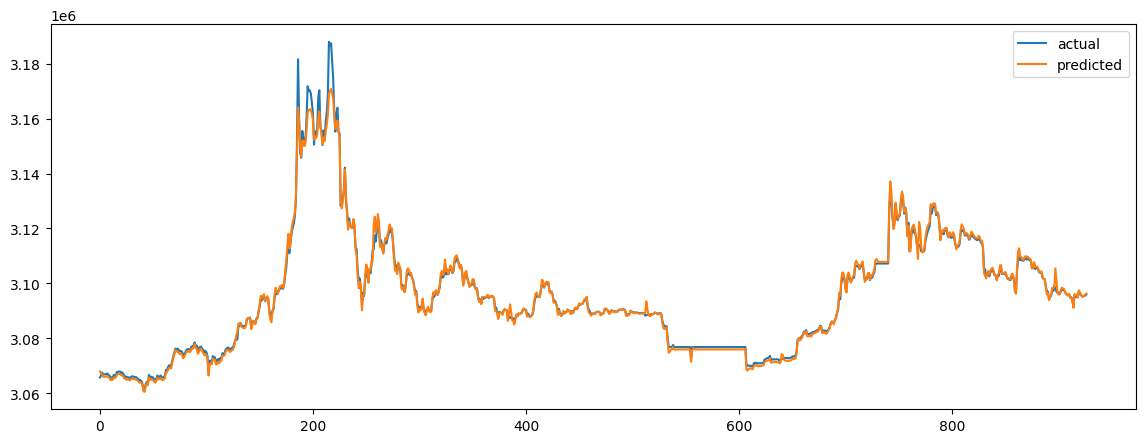

In [75]:
show_plot(model, train_loader, device)

100%|██████████| 2/2 [00:00<00:00, 26.35it/s]


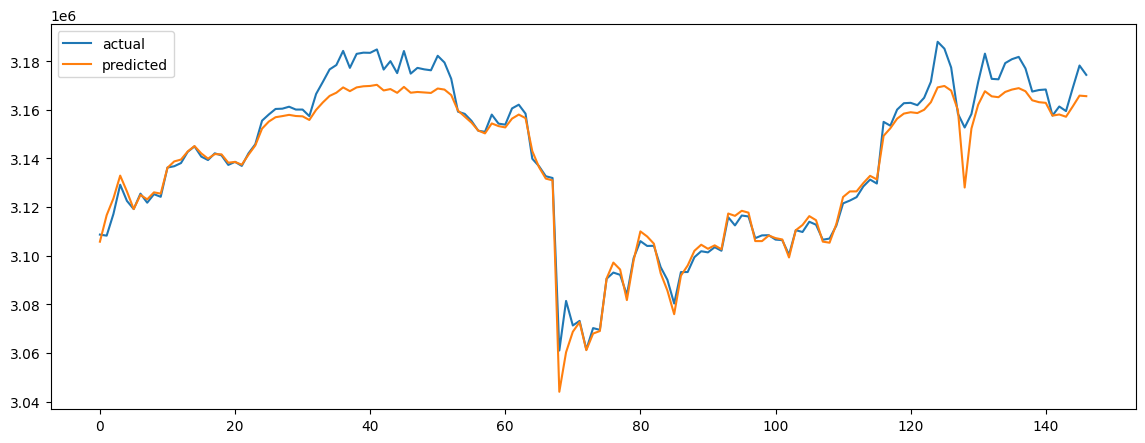

In [76]:
show_plot(model, val_loader, device)

100%|██████████| 2/2 [00:00<00:00, 25.54it/s]


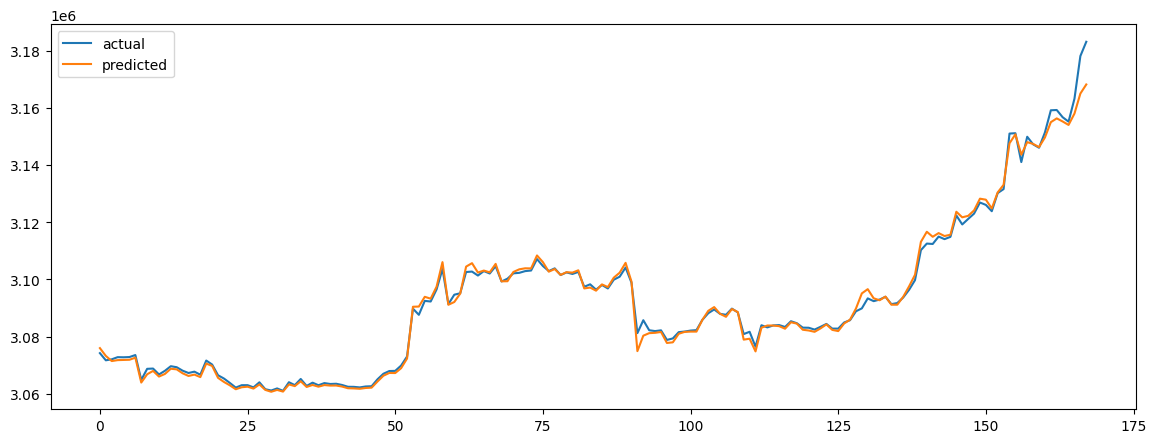

In [77]:
show_plot(model, test_loader, device)